# Text feature extraction

In [1]:
import ssl

# Set the path to the CA certificates bundle
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import string

# set plot style
sns.set_theme()

In [3]:
# nltk.download()
# or you can download directly, i.e.
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from nltk.corpus import stopwords

Continuing with our `MBTI` dataset, let's read the data and clean it up a bit.

In [5]:
# Read the MBTI dataset
mbti = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/classification_sprint/mbti_train.csv')
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
mbti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6506 entries, 0 to 6505
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    6506 non-null   object
 1   posts   6506 non-null   object
dtypes: object(2)
memory usage: 101.8+ KB


In [7]:
# Separate each post in the 'posts' column into its own row
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

all_mbti

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
...,...,...
316543,INFP,"Kallinhausin, you may have just rooted out the..."
316544,INFP,"In regards to the king, (in the show, not in t..."
316545,INFP,Sunlight bouncing off the fog at dawn. Serend...
316546,INFP,Songs are really powerful.


In [8]:
#Remove noise
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)
all_mbti['post'] = all_mbti['post'].str.lower()

#Remove punctuation
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

all_mbti['post'] = all_mbti['post'].apply(remove_punctuation)

# Tokenise the text using the TreebankWordTokenizer
tokeniser = TreebankWordTokenizer()
all_mbti['tokens'] = all_mbti['post'].apply(tokeniser.tokenize)


## Text feature extraction

### Bag-of-words

Text feature extraction is the process of transforming what is essentially a list of words into a feature set that is usable by a classifier. The NLTK classifiers expect `dict` style feature sets, so we must therefore transform our text into a Python dictionary object. The bag-of-words model is the simplest method; it constructs a word presence feature set from all the words in the text, indicating the number of times each word has appeared.

In [9]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

Here we create a set of dictionaries, one for each of the MBTI types.

In [10]:
#Create a list of all the MBTI personality types that are present in the original dataset
type_labels = list(all_mbti.type.unique())

In [11]:
personality = {}
for pp in type_labels:
    df = all_mbti.groupby('type')
    personality[pp] = {}
    for row in df.get_group(pp)['tokens']:
        personality[pp] = bag_of_words_count(row, personality[pp])

Next, we create a list of all of the unique words.

In [12]:
all_words = set()
for pp in type_labels:
    for word in personality[pp]:
        all_words.add(word)

This was done so that we can create a combined bag-of-words dictionary for all the words in the text.

In [13]:
personality['all'] = {}
for pp in type_labels:
    for word in all_words:
        if word in personality[pp].keys():
            if word in personality['all']:
                personality['all'][word] += personality[pp][word]
            else:
                personality['all'][word] = personality[pp][word]

Now we can easily calculate how many words there are in total.

In [14]:
total_words = sum([v for v in personality['all'].values()])
total_words

8203466

Let's take a look at the distribution of words which occur fewer than 10 times in the whole dataset.

Text(0.5, 0, 'word frequency')

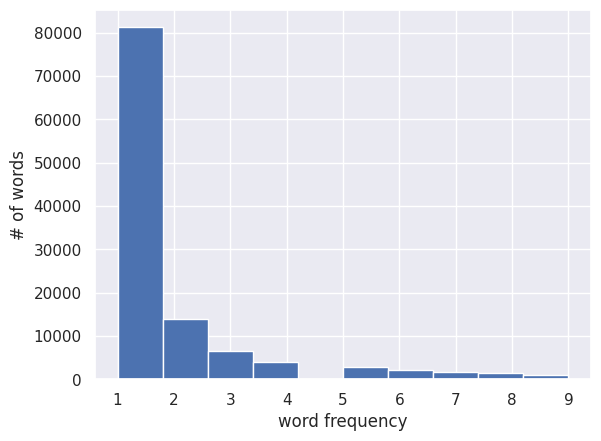

In [15]:
_ = plt.hist([v for v in personality['all'].values() if v < 10],bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")

There are a lot of words that only appear once! We'll print out that value here.

In [16]:
len([v for v in personality['all'].values() if v == 1])

81268

What kind of words do you think would appear once? Let's print out a few of these rare words.

In [17]:
rare_words = [k for k, v in personality['all'].items() if v==1]
print(rare_words[:100])

['girders', 'pinkrose', 'babysat', 'outgoingin', 'diversityand', 'happenactually', 'moonrube', 'angel”', 'ayurvedayogafaith', 'orso', 'crownopen56', 'faintbutparanoialaced', 'actionscififantasy', 'updatesolution', 'estpsenfps', 'absodamnedlutely', 'eitherat', 'nicentric', 'hunterfisher', 'emoji184', 'additive', 'insanedysfunctional', 'epressing', 'peole', 'delusionshallucinations', 'cutessst', 'houuuuuuuuuuuuse', 'elephantality', 'ringtailed', 'stubbornest', 'laurelwren', 'adamantya', 'strugglesjoys', 'lingustic', 'chainfob', '4047', 'idabes', 'sirenproud', 'weirdannoying', 'tubas', 'thunders', 'confirmedlaughing', 'explaing', 'beautifuli', 'wholistic', 'namelast', '343569', 'erring', 'responsesi', 'corleo', 'outsorted', 'yerself', '86051', 'arrrrggghhhh', 'myselfdid', 'mogeko', 'hooohrahhh', 'infjour', 'wulfing', 'redtailed', '478266', 'dissociating', 'twentythousand', 'sortaserious', 'couchsurfing', 'baddunno', 'thatwelcome', '×able', 'anxietyinducing', 'philosopherinfjs', '8000wordo

As you can see, some of these words don't make sense. But before we decide to remove them, let's see how much data we'll be left with.

In [18]:
# How many words appear more than 10 times?
# How many words of the total does that account for?
print(len([v for v in personality['all'].values() if v >= 10]))
occurs_more_than_10_times = sum([v for v in personality['all'].values() if v >= 10])
print(occurs_more_than_10_times)

18193
7998579


In [19]:
occurs_more_than_10_times/total_words

0.9750243372740254

Using words that appear more than 10 times seems much more useful!  And this accounts for 97% of all the words!

Finally, let's remove all words that occur fewer than 10 times.

In [20]:
max_count = 10
remaining_word_index = [k for k, v in personality['all'].items() if v > max_count]

### Hypothesis testing
Remember our hypothesis from earlier?

- Introverts tend to use the word `I` more than extroverts.
- Conversely, extroverts tend to favour the word `you`.

Let's see if we finally have what we need to test it out. We'll first create one big DataFrame with the word counts by personality profile (this may take a while).

In [21]:
hm = []
for p, p_bow in personality.items():
    df_bow = pd.DataFrame([(k, v) for k, v in p_bow.items() if k in remaining_word_index], columns=['Word', p])
    df_bow.set_index('Word', inplace=True)
    hm.append(df_bow)

# Create one big DataFrame
df_bow = pd.concat(hm, axis=1)
df_bow.fillna(0, inplace=True)

What are the top 10 words which appear most often?

In [22]:
df_bow.sort_values(by='all', ascending=False).head(10)

,INFJ,ENTP,INTP,INTJ,ENTJ,ENFJ,INFP,ENFP,ISFP,ISTP,ISFJ,ISTJ,ESTP,ESFP,ESTJ,ESFJ,all
Word,,,,,,,,,,,,,,,,,
i,67821.0,27381.0,52046.0,43810.0,8875.0,8683.0,87642.0,31156.0,11148.0,13883.0,8037.0,8169.0,3704.0,1696.0,1856.0,2166.0,378073
the,39658.0,18993.0,35864.0,30497.0,6132.0,5018.0,48004.0,16454.0,6131.0,8893.0,4111.0,5141.0,2191.0,937.0,1000.0,1200.0,230224
to,40231.0,17852.0,33005.0,28753.0,5889.0,5471.0,48996.0,16945.0,6264.0,8725.0,4607.0,5106.0,2254.0,972.0,1078.0,1223.0,227371
a,31931.0,14728.0,26692.0,22778.0,4748.0,3966.0,40375.0,13846.0,4825.0,7124.0,3333.0,4033.0,1868.0,796.0,841.0,986.0,182870
and,31628.0,14236.0,24880.0,21568.0,4564.0,4343.0,40709.0,15002.0,5153.0,6540.0,3571.0,3827.0,1905.0,834.0,943.0,988.0,180691
of,24312.0,11335.0,21372.0,17857.0,3499.0,3114.0,29576.0,10217.0,3580.0,4962.0,2475.0,2976.0,1300.0,557.0,650.0,779.0,138561
you,22207.0,10870.0,17186.0,15997.0,3815.0,3048.0,24954.0,10315.0,3331.0,4696.0,2185.0,2731.0,1396.0,651.0,651.0,639.0,124672
that,19444.0,8947.0,16384.0,14432.0,2906.0,2611.0,23437.0,8583.0,2931.0,4054.0,2033.0,2207.0,1063.0,550.0,521.0,615.0,110718
it,18357.0,8257.0,15685.0,13167.0,2601.0,2278.0,22511.0,8010.0,2909.0,4244.0,2046.0,2285.0,1065.0,434.0,469.0,490.0,104808


This isn't very helpful at all, is it? It's very difficult to extract insights from this data.  Let's see if we can use the $chi^2$ test to see whether introverts favour the word **`I`**.

The $chi^2$ test looks at observed versus expected results and lets us know where the greatest differences from expected values are.  The bigger the statistic, the greater the difference from expectation.  The formula is

$$𝑐ℎ𝑖^2 = \sum{\frac{(𝑂𝑏𝑠𝑒𝑟𝑣𝑒𝑑 −𝑒𝑥𝑝𝑒𝑐𝑡𝑒𝑑)^2}{𝑒𝑥𝑝𝑒𝑐𝑡𝑒𝑑}}$$

The $chi^2$ test will compare the **observed frequencies** of word usage by **introverts** to the **expected frequencies** based on the overall population and indicate the extent of this difference for each word.

Using the $chi^2$ statistic over simply comparing the observed percentages, i.e. `I_perc`, means that we are considering both the observed (or word usage by introverts) and expected frequencies (or the overall population's word usage) for each word, taking into account the sample size. This helps us determine whether the differences between observed and expected frequencies are statistically significant, accounting for variability due to sample size.

We'll do this first by extracting introvert types only from all the personality types.

In [23]:
intro_types_i = [p for p in type_labels if p[0] == 'I']

Next, we'll create an introvert total word count column, which sums the counts of all introvert columns.

In [24]:
df_bow['I'] = df_bow[intro_types_i].sum(axis=1)

Now we'll calculate and add percentage columns.

In [25]:
for col in ['I', 'all']:
    df_bow[col+'_perc'] = df_bow[col] / df_bow[col].sum()

Print off the DataFrame to view what we've done.

In [26]:
df_bow.sort_values(by='all', ascending=False).head(5)

,INFJ,ENTP,INTP,INTJ,ENTJ,ENFJ,INFP,ENFP,ISFP,ISTP,ISFJ,ISTJ,ESTP,ESFP,ESTJ,ESFJ,all,I,I_perc,all_perc
Word,,,,,,,,,,,,,,,,,,,,
i,67821.0,27381.0,52046.0,43810.0,8875.0,8683.0,87642.0,31156.0,11148.0,13883.0,8037.0,8169.0,3704.0,1696.0,1856.0,2166.0,378073,292556.0,0.047701,0.047328
the,39658.0,18993.0,35864.0,30497.0,6132.0,5018.0,48004.0,16454.0,6131.0,8893.0,4111.0,5141.0,2191.0,937.0,1000.0,1200.0,230224,178299.0,0.029071,0.028820
to,40231.0,17852.0,33005.0,28753.0,5889.0,5471.0,48996.0,16945.0,6264.0,8725.0,4607.0,5106.0,2254.0,972.0,1078.0,1223.0,227371,175687.0,0.028646,0.028463
a,31931.0,14728.0,26692.0,22778.0,4748.0,3966.0,40375.0,13846.0,4825.0,7124.0,3333.0,4033.0,1868.0,796.0,841.0,986.0,182870,141091.0,0.023005,0.022892
and,31628.0,14236.0,24880.0,21568.0,4564.0,4343.0,40709.0,15002.0,5153.0,6540.0,3571.0,3827.0,1905.0,834.0,943.0,988.0,180691,137876.0,0.022481,0.022619


In [27]:
# calculate chi2
df_bow['chi2_i'] = np.power((df_bow['I_perc'] - df_bow['all_perc']), 2) / df_bow['all_perc']

In [28]:
df_bow[['I_perc', 'all_perc', 'chi2_i']][df_bow['I_perc'] > df_bow['all_perc']].sort_values(by='chi2_i', ascending=False).head(10)

,I_perc,all_perc,chi2_i
Word,,,
urlweb,0.002817,0.002615,0.000016
infp,0.001249,0.001118,0.000015
infj,0.001111,0.001019,0.000008
infps,0.000466,0.000413,0.000007
infjs,0.000393,0.000347,0.000006
intp,0.000936,0.000871,0.000005
my,0.012057,0.011859,0.000003
intps,0.000346,0.000315,0.000003
i,0.047701,0.047328,0.000003


And there it is! What can we conclude from this?

Looking at the top words with higher chi-square values, we can see that words like "urlweb", "infp", "infj", as well as "i" have the top chi-square values compared to others. This indicates that these words are used more frequently by introverts than would be expected based on their overall occurrence in the dataset.

The word "I" appears 9th in the top 10 highest chi-square values of 0.000003, suggesting that its usage by introverts deviates significantly from what would be expected based on its general frequency.

Therefore, based on these findings, we can conclude that introverts tend to use "I" more frequently than extroverts, supporting the hypothesis that introverts favour the use of the word "I".

Let's now have a look at the words most used by extroverts, following the same process but for extrovert types.

In [29]:
#extract extrovert types only from all the personality types
intro_types_e = [p for p in type_labels if p[0] == 'E']
#Create an extrovert total word count column, which sums the counts of all extrovert columns
df_bow['E'] = df_bow[intro_types_e].sum(axis=1)
#calculate and add a percentage column for extroverts
df_bow['E_perc'] = df_bow['E'] / df_bow['E'].sum()
# calculate chi2 for extroverts
df_bow['chi2_e'] = np.power((df_bow['E_perc'] - df_bow['all_perc']), 2) / df_bow['all_perc']
df_bow[['E_perc', 'all_perc', 'chi2_e']][df_bow['E_perc'] > df_bow['all_perc']].sort_values(by='chi2_e', ascending=False).head(15)

,E_perc,all_perc,chi2_e
Word,,,
enfp,0.001632,0.000728,0.001124
entp,0.001474,0.000631,0.001124
entps,0.000599,0.000226,0.000619
enfps,0.000555,0.000228,0.000468
entj,0.000738,0.000360,0.000397
enfj,0.000631,0.000356,0.000213
estp,0.000517,0.000289,0.000181
entjs,0.000241,0.000105,0.000176
d,0.000657,0.000424,0.000127


Based on the chi-squared analysis, there is evidence to suggest that extroverts tend to use words like "enfp", "entp", "entps", and "enfps", as well as "you" more frequently compared to their overall usage. This supports our hypothesis.

### n-grams

While individual words do carry meaning, it is often the case that combinations of words change meanings of sentences entirely.  For example, what difference does removing the `not` from a sentence make?

Natural language processing is **not** easy!

n-grams are a method to extract combinations of words into features for model building.  The `n` in n-grams specifies the number of tokens to include.  For example, a 2-gram returns all the consecutive pairs of words in a sentence.

In [32]:
from nltk.util import ngrams

In [33]:
def word_grams(words, min_n=1, max_n=4):
    s = []
    for n in range(min_n, max_n):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [34]:
print (word_grams('one two three four'.split(' ')))

['one', 'two', 'three', 'four', 'one two', 'two three', 'three four', 'one two three', 'two three four']


Let's combine consecutive words into groups of two using n-grams.

In [35]:
[x for x in ngrams(all_mbti.iloc[55555]['tokens'], 2)]

[('i', 'find'),
 ('find', 'all'),
 ('all', 'of'),
 ('of', 'you'),
 ('you', 'to'),
 ('to', 'be'),
 ('be', 'extremely'),
 ('extremely', 'humorous'),
 ('humorous', 'now'),
 ('now', 'to'),
 ('to', 'find'),
 ('find', 'other'),
 ('other', 'specimen'),
 ('specimen', 'to'),
 ('to', 'observe')]

Now let's combine consecutive words into groups of three using n-grams.

In [36]:
[x for x in ngrams(all_mbti.iloc[55555]['tokens'], 3)]

[('i', 'find', 'all'),
 ('find', 'all', 'of'),
 ('all', 'of', 'you'),
 ('of', 'you', 'to'),
 ('you', 'to', 'be'),
 ('to', 'be', 'extremely'),
 ('be', 'extremely', 'humorous'),
 ('extremely', 'humorous', 'now'),
 ('humorous', 'now', 'to'),
 ('now', 'to', 'find'),
 ('to', 'find', 'other'),
 ('find', 'other', 'specimen'),
 ('other', 'specimen', 'to'),
 ('specimen', 'to', 'observe')]

## Now that we understand all of that, let's cheat!

**Praise be to Python...**

`sklearn` has a built-in text feature extraction module called [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that will literally do all of that work in one line of code! This function will convert a collection of documents (rows of text) into a matrix of token counts.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# Initialise CountVectorizer
vect = CountVectorizer()
# Fit the CountVectorizer on the preprocessed 'post' column
vect.fit(all_mbti['post'])

CountVectorizer()

### Tuning the vectorizer

We have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune with examples on how to do so:

- **stop_words:** string 'english', list, or None (default)
    * If 'english', a built-in stop word list for English is used.
    * If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    * If None, no stop words will be used.

In [39]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [40]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [41]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [42]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

### Guidelines for tuning CountVectorizer:

- Use your knowledge of the **problem** and the **text**, and your understanding of the **tuning parameters**, to help you decide what parameters to tune and how to tune them.
- **Experiment**, and let the data tell you the best approach!

Finally, let's fit a tuned CountVectorizer to the MBTI data.

In [43]:
betterVect = CountVectorizer(stop_words='english',
                             min_df=2,
                             max_df=0.5,
                             ngram_range=(1, 1))

In [44]:
betterVect.fit(all_mbti['post'])

CountVectorizer(max_df=0.5, min_df=2, stop_words='english')

After vectorization using `CountVectorizer`, we can view the transformed data as a matrix where each row represents a document (post in our case) and each column represents a unique word in the vocabulary. The cell values indicate the count of the corresponding word in each document.

It's essential to note that this process generates a very large dataset, potentially consuming significant memory on your machine.

Uncomment the code below if you would still want to view the vectorized data.

In [ ]:
"""
# Transform the training data
vectorized_data = betterVect.transform(all_mbti['post'][0:10000,])

# Convert the sparse matrix to a dense array for easier viewing (optional)
dense_vectorized_data = vectorized_data.toarray()

# Create a DataFrame to display the vectorized data
vectorized_df = pd.DataFrame(dense_vectorized_data, columns=betterVect.get_feature_names_out())

# Display the vectorized DataFrame
print(vectorized_df)
"""